# Results Analysis

## Imports

In [1]:
!pip install -q pandas seaborn


[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

## Definitions

### Constants

In [3]:
RESULT_DIR  = '../results/'

#### Strategies

In [4]:
CLASSIC = {'random_sampling', 'margin_sampling', 'training_utility_sampling', 'density_weighted_sampling', 'expected_error_reduction'}
NEIGHBORHOOD = {'borderline_points_sampling', 'k_disagreeing_neighbors_sampling', 'local_set_cardinality_sampling',
                'ls_radius_sampling', 'intra_extra_ratio_sampling', 'harmfulness_sampling', 'usefulness_sampling'}
LIKELIHOOD = {'class_likelihood_sampling', 'class_likeliood_diff_sampling'}
FEATURE_BASED = {'f1_sampling', 'f2_sampling', 'f3_sampling', 'f4_sampling'}
TREE_BASED = {'disjunct_class_percentage_sampling', 'disjunct_size_sampling', 'tree_depth_pruned_sampling',
              'tree_depth_unpruned_sampling'}
CLASS_BALANCE = {'class_balance_sampling', 'minority_value_sampling'}

### Helper Functions

In [95]:
def get_hm_type(x: str):
    if x in CLASSIC: return 'Classic'
    if x in NEIGHBORHOOD: return 'Neighbor-based'
    if x in LIKELIHOOD: return 'Likelihood-based'
    if x in FEATURE_BASED: return 'Feature-based'
    if x in TREE_BASED: return 'Tree-based'
    if x in CLASS_BALANCE: return 'Class-Balance'
        

In [5]:
def sort_curves(x: pd.Index):
    return x.map(lambda y: (not y in CLASSIC,
                            not y in NEIGHBORHOOD,
                            not y in LIKELIHOOD,
                            not y in FEATURE_BASED,
                            not y in TREE_BASED,
                            y))

In [6]:
def get_style(method):
    if method == 'random_sampling':
        return '--'
    elif method in CLASSIC:
        return '-'
    elif method in NEIGHBORHOOD:
        return '^-.'
    elif method in LIKELIHOOD:
        return 's-.'
    elif method in FEATURE_BASED:
        return '*-.'
    elif method in TREE_BASED:
        return 'h-.'
    else:
        return 'd-.'

In [7]:
def show_counts(df, model, ax):
    df = df.loc[:,model,:]
    df.reset_index().strategy.value_counts().sort_index(ascending=False).plot(
        ax=ax, kind='barh', grid=True, title=model, xlim=(0,100), xticks=range(0, 101, 10),
        sharey=True, figsize=(16,8), xlabel='Experiments count')

### Learning Curves

In [8]:
def plot_learning_curves(df, dataset, classifier):
    color_list = sns.color_palette(n_colors=len(df.columns))
    
    local_df = df.loc[(dataset, classifier)].sort_index(key=sort_curves).T
    
    for i, column in enumerate(local_df.columns):
        # Aplica média móvel
        scores = local_df[column].rolling(window=5).mean()
        plt.plot(local_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 markevery=10)

    
    # Ordenação de legenda
    plt.legend(ncol=2)
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.grid()
   
    # Titulo
    plt.title(dataset)
    plt.xlabel('Query')
    plt.ylabel('f1-score (macro)')

    

In [9]:
def show_all_learning_curves(df, model):

    for dataset in df.index.levels[0]:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', Warning)
        plot_learning_curves(df, dataset=str(dataset), classifier=model)    

        display(plt.gcf())
        
        if input() == 'q':
            break

        clear_output(wait=True)
        plt.close()
    plt.close()

### Ranking Curves

In [10]:
def plot_ranking_curves(data: pd.DataFrame, model:str, group_strategies=False):

    ranked_df = df.loc[:, model, :].groupby('dataset').rank(ascending=False)
    
    mean_rank_df = ranked_df.groupby('strategy').mean().sort_index(key=sort_curves).T

    color_list = sns.color_palette(n_colors=len(mean_rank_df.columns))
    
    for i, column in enumerate(mean_rank_df.columns):
        # Aplica média móvel
        scores = mean_rank_df[column].rolling(window=5, min_periods=1).mean()

        plt.plot(mean_rank_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 linewidth=0.7,
                 markevery=(0.3, 0.2))


    plt.gca().invert_yaxis()
    
    # Ordenação de legenda
    plt.legend(bbox_to_anchor=(1.01,1), ncol=1, shadow=True)

    # Grid
    plt.grid()
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    
   
    # Titulo
    plt.title(f'Ranking Curves ({model})')
    plt.xlabel('Query')
    plt.ylabel('Avg. Rank')

# plot_ranking_curves(df, 'SVC')

In [37]:
def plot_ranks_with_bands(df, model=None, log=False):
    
    ranked_df = df.groupby('dataset').rank(ascending=False).groupby(['model','strategy']).mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')

    # Plot Bands
    for model_name, df in ranked_df_smoothed.groupby('model'):
        plt.fill_between(np.arange(df.shape[1]), df.max(), df.min(),
                         alpha=0.1, label=model_name)

    plt.title(model)
    if model is None:
    # Plot Best Strategy for each model
        for model, df in ranked_df_smoothed.groupby('model'):
            best_strategy = auc_series.loc[model].idxmax()
            
            plt.plot(ranked_df_smoothed.loc[model, best_strategy],
                     get_style(best_strategy),
                     label=' + '.join([model,best_strategy]),
                     markevery=(50,50),
                     linewidth=0.8)
            
            # worst_strategy = auc_series.loc[model].idxmin()
            # plt.plot(ranked_df_smoothed.loc[model, worst_strategy],
            #          get_style(best_strategy),
            #          label=' + '.join([model,worst_strategy]),
            #          markevery=(50,50),
            #          linewidth=0.8)
    else:
        
        color_list = sns.color_palette(n_colors=len(ranked_df_smoothed.columns))

        for i, (strategy, row) in  enumerate(ranked_df_smoothed.loc[model].iterrows()):
            plt.plot(ranked_df_smoothed.loc[model, strategy],
                     get_style(strategy),
                     label=strategy,
                     color=color_list[i],
                     markevery=(0.3, 0.2),
                     linewidth=0.8)
        

    plt.xticks(range(0, 100, 10))
    plt.grid()
    plt.xlabel('Queries')
    plt.ylabel('Mean Ranking Position')
    plt.legend(bbox_to_anchor=(1.04,1), ncol=1)
    plt.gca().invert_yaxis()

    if log == True:
        plt.xscale('log')
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(10, 8)

## Data Gathering

In [23]:
RESULT_FILES = !find $RESULT_DIR -type f 

In [24]:
data = {
    os.path.splitext(os.path.basename(f))[0]: pd.read_csv(f, index_col=0).mean(axis='columns')
    for f in RESULT_FILES
}

In [14]:
index_columns = ['dataset', 'model', 'strategy']

In [74]:
df = pd.DataFrame(data).T.reset_index(names='file_name')
df[index_columns] = df.file_name.str.split('#', expand=True)
df = df.set_index(index_columns).drop(columns='file_name')

Remove observações para EER, pois só foram feitas para SVM:

In [30]:
df.index.levels[2].unique()

Index(['borderline_points_sampling', 'class_balance_sampling',
       'class_likelihood_sampling', 'class_likeliood_diff_sampling',
       'density_weighted_sampling', 'disjunct_class_percentage_sampling',
       'disjunct_size_sampling', 'expected_error_reduction', 'f1_sampling',
       'f2_sampling', 'f3_sampling', 'f4_sampling', 'harmfulness_sampling',
       'intra_extra_ratio_sampling', 'k_disagreeing_neighbors_sampling',
       'local_set_cardinality_sampling', 'ls_radius_sampling',
       'margin_sampling', 'minority_value_sampling', 'random_sampling',
       'training_utility_sampling', 'tree_depth_pruned_sampling',
       'tree_depth_unpruned_sampling', 'usefulness_sampling'],
      dtype='object', name='strategy')

## Data Analysis

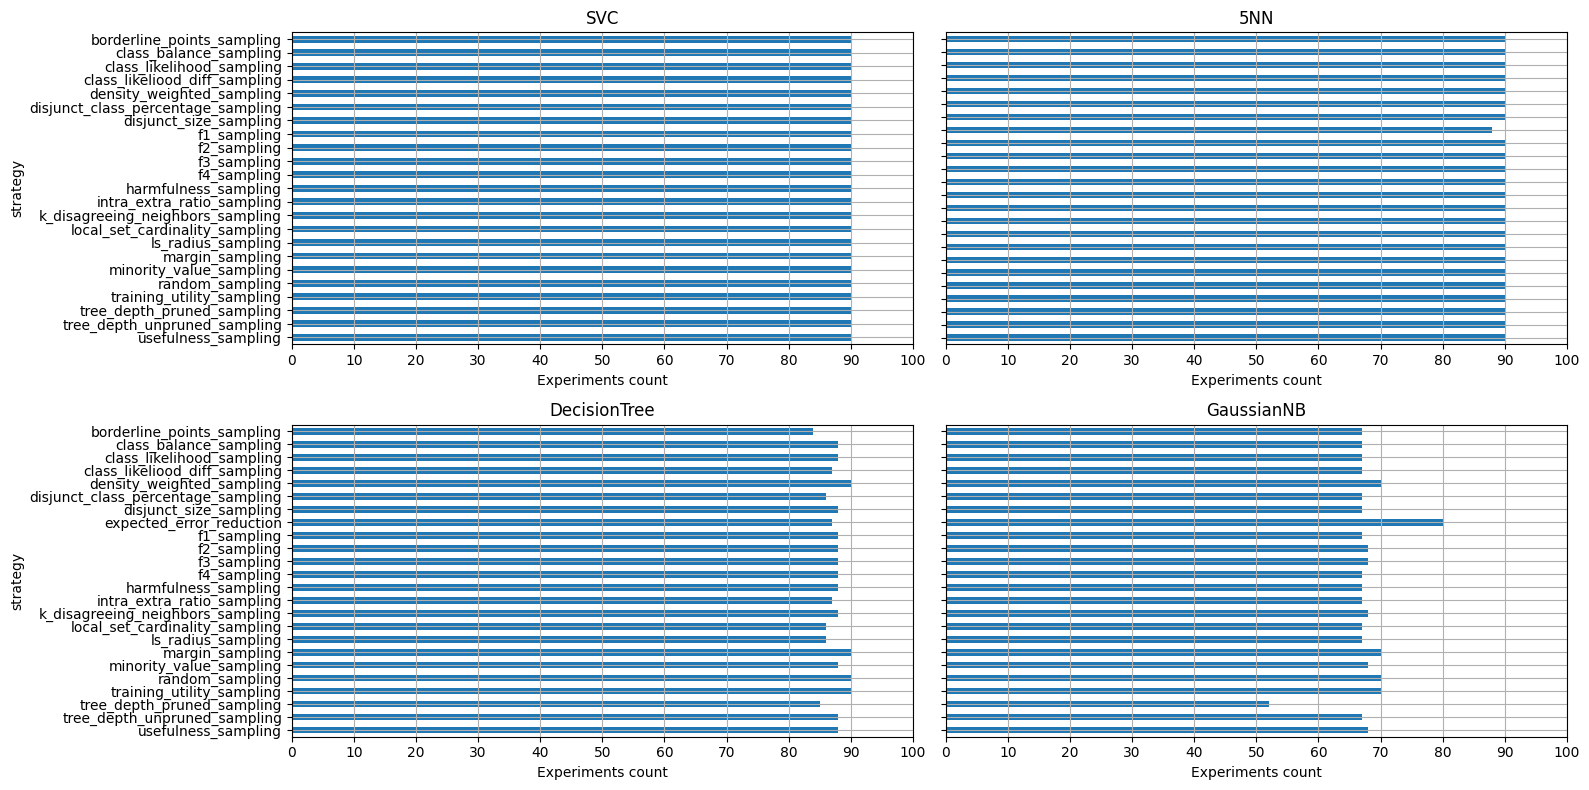

In [26]:
fig, axs = plt.subplots(2,2)

show_counts(df, ax=axs[0, 0], model='SVC')
show_counts(df, ax=axs[0, 1], model='5NN')
show_counts(df, ax=axs[1, 0], model='DecisionTree')
show_counts(df, ax=axs[1, 1], model='GaussianNB')

fig.tight_layout()

## Ranking Curves

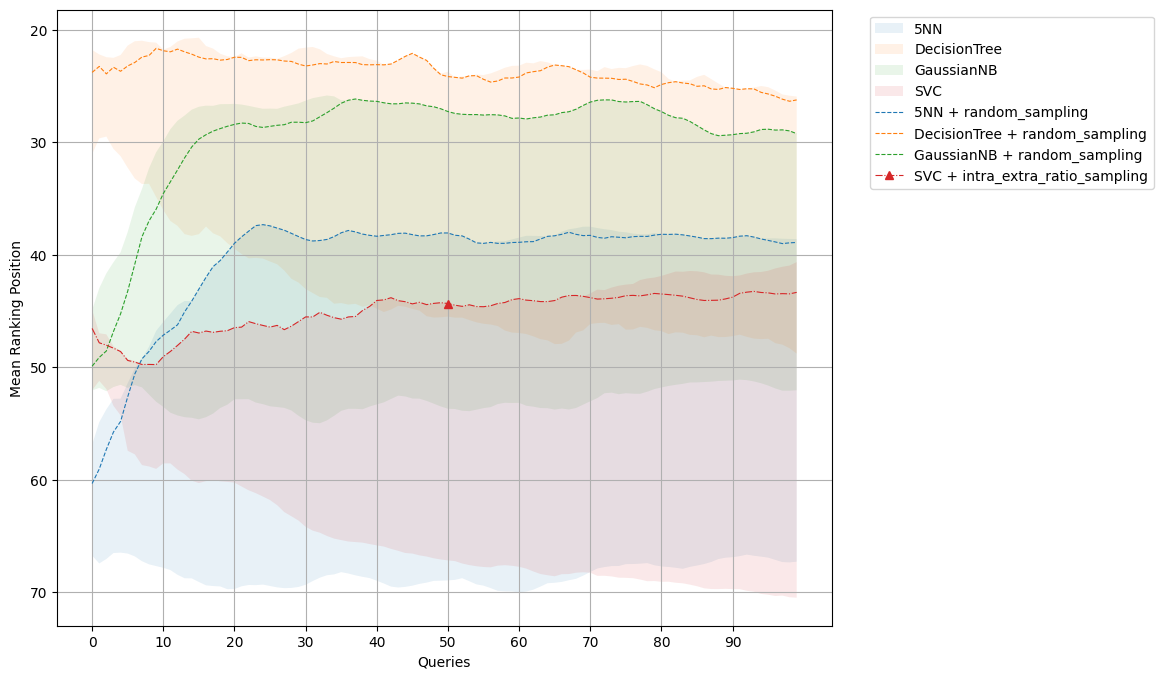

In [31]:
plot_ranks_with_bands(df)

### SVC

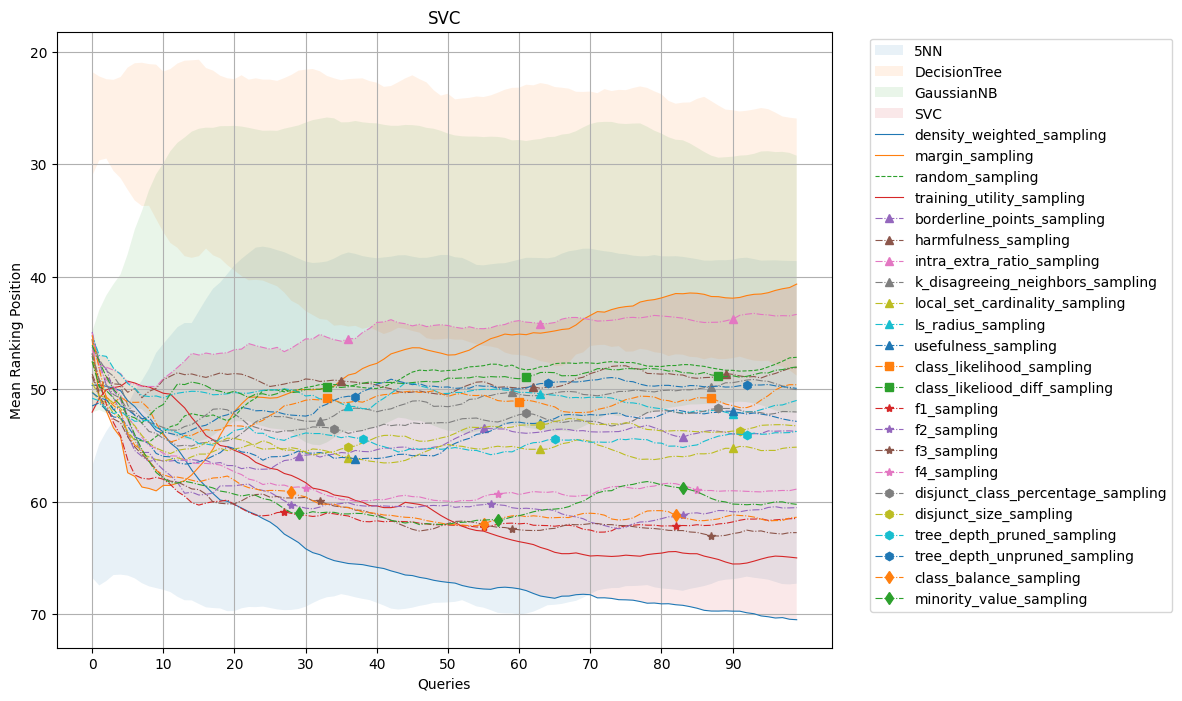

In [32]:
plot_ranks_with_bands(df, model='SVC')

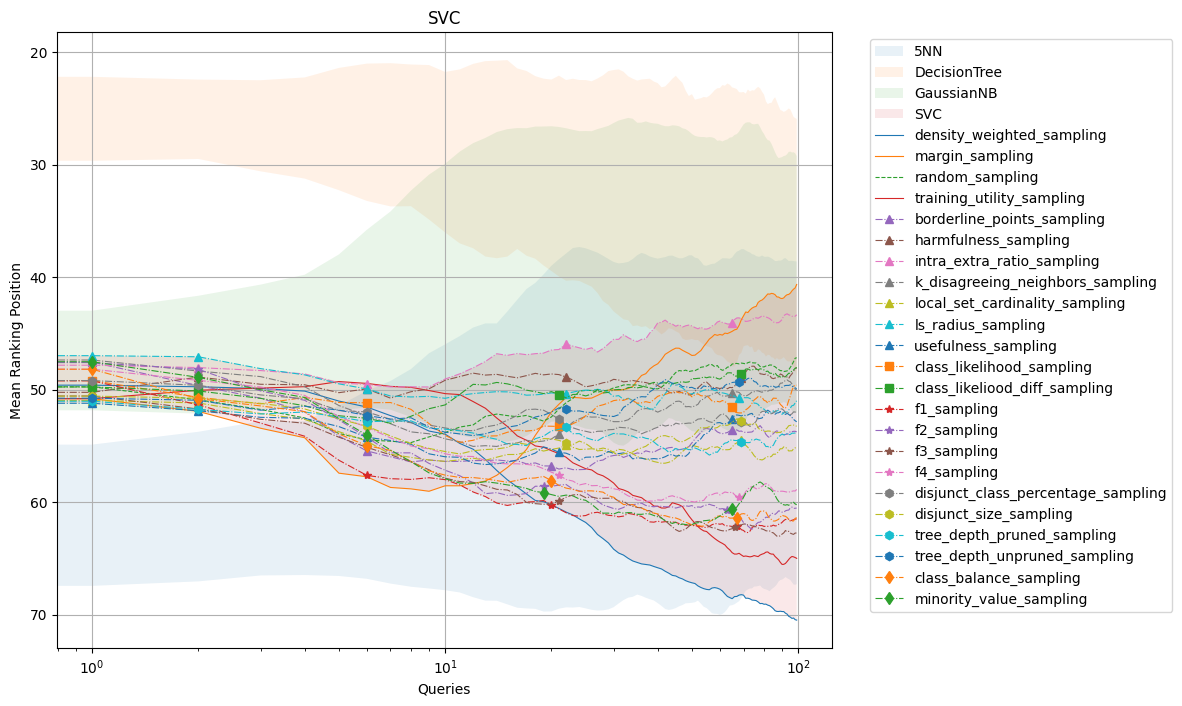

In [38]:
plot_ranks_with_bands(df, model='SVC',log=True)

### KNN

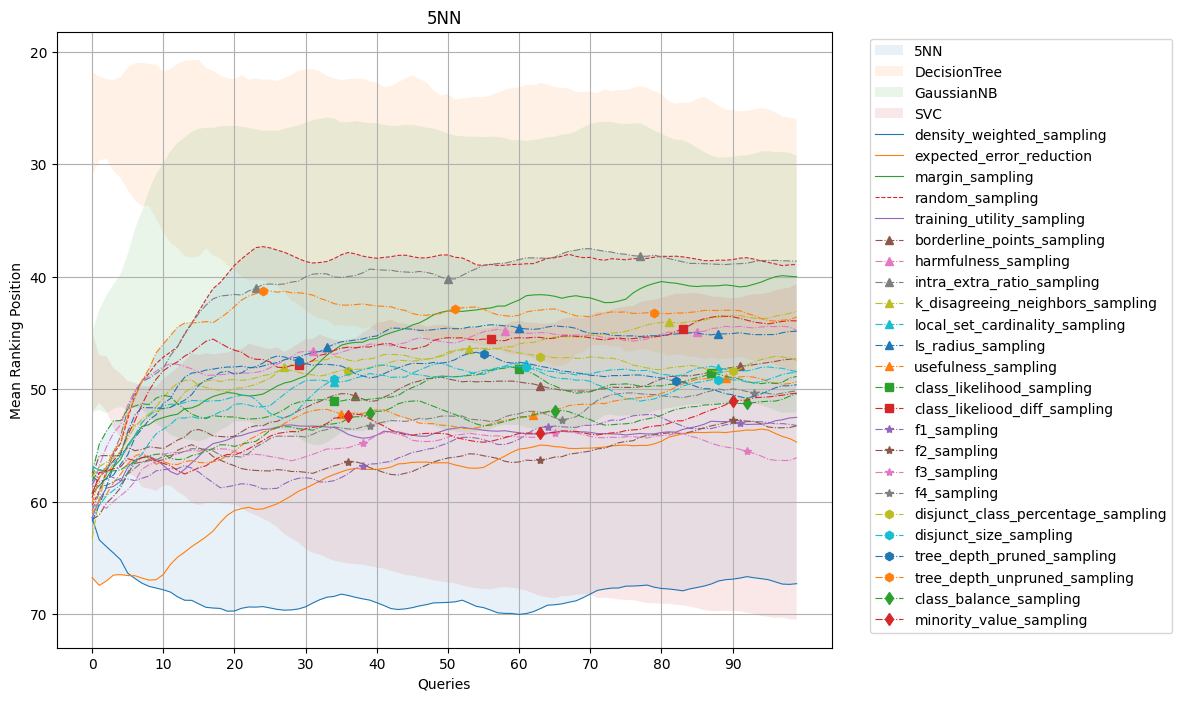

In [33]:
plot_ranks_with_bands(df, model='5NN')

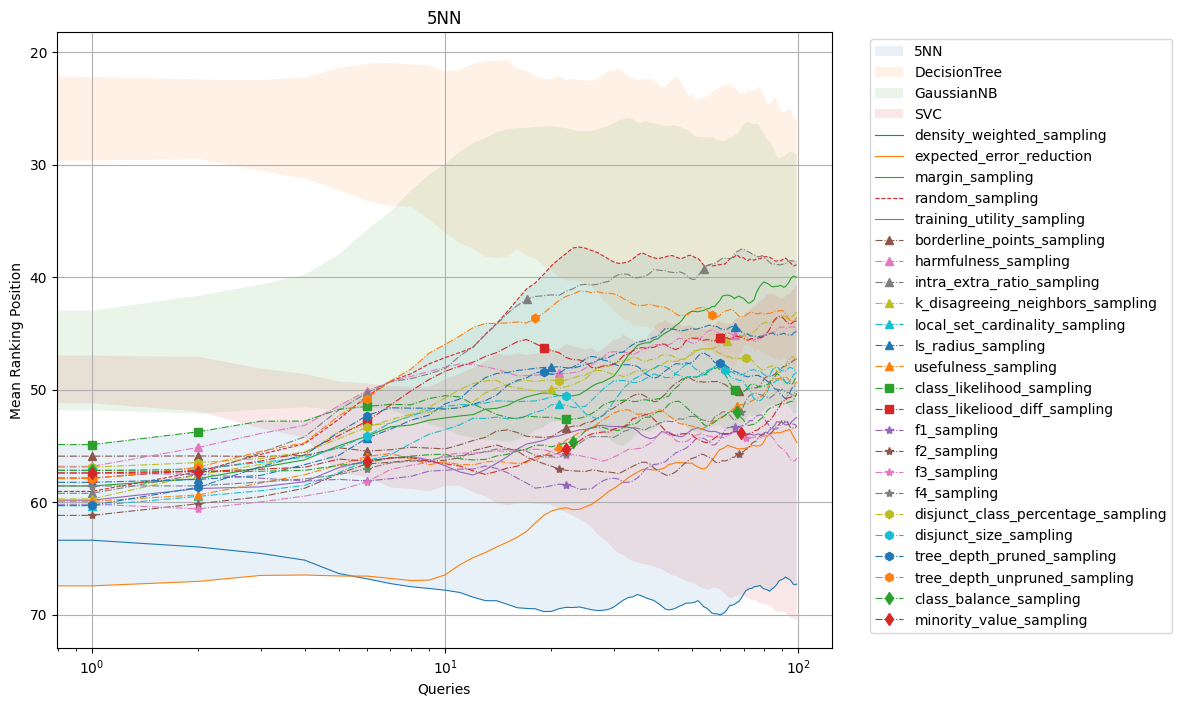

In [40]:
plot_ranks_with_bands(df, model='5NN', log=True)

### Decision Tree

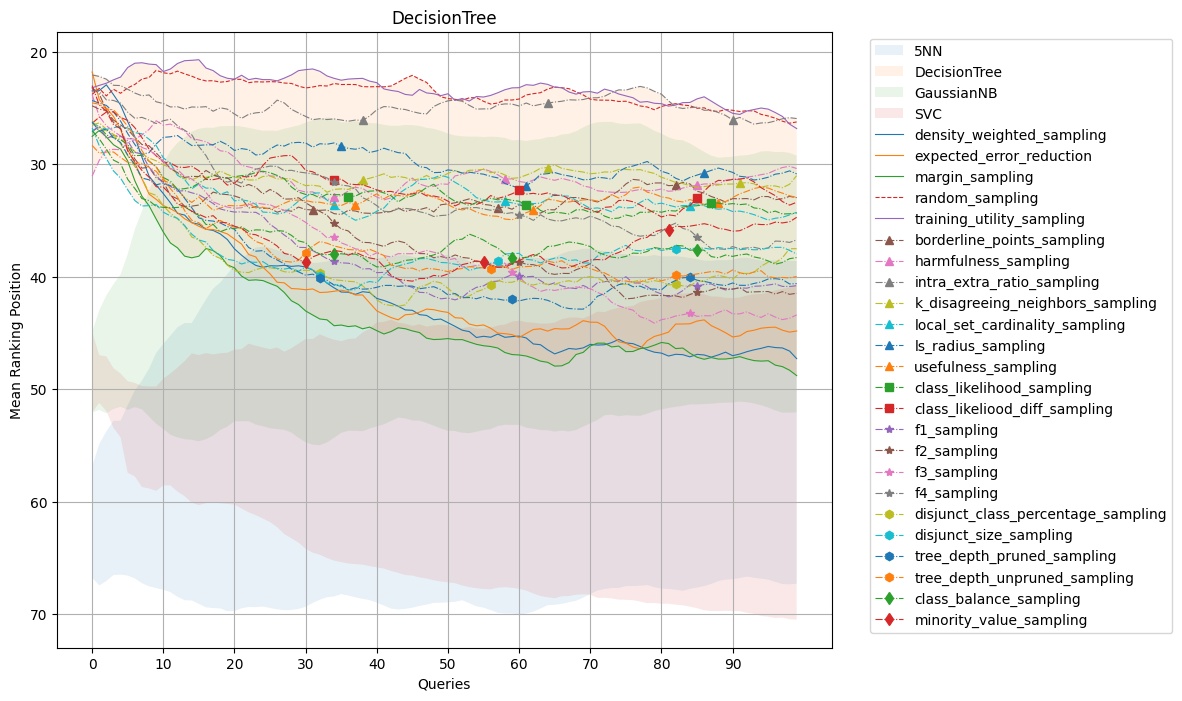

In [34]:
plot_ranks_with_bands(df, model='DecisionTree')

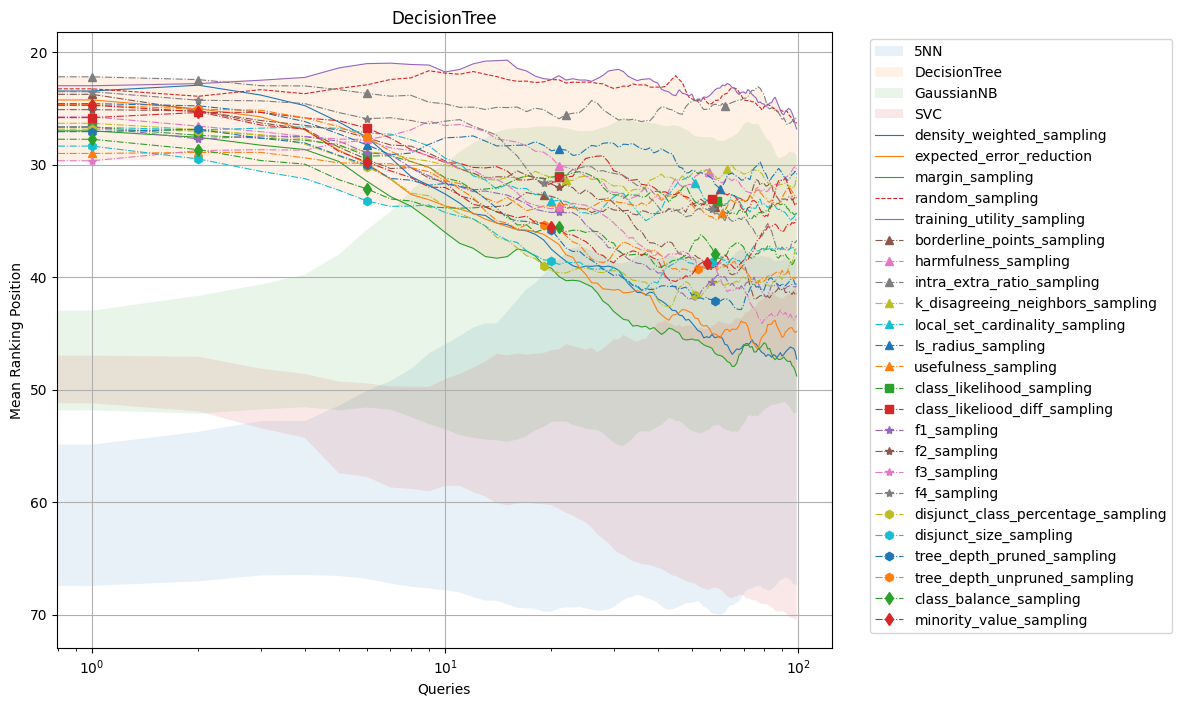

In [41]:
plot_ranks_with_bands(df, model='DecisionTree', log=True)

### Gaussian NB

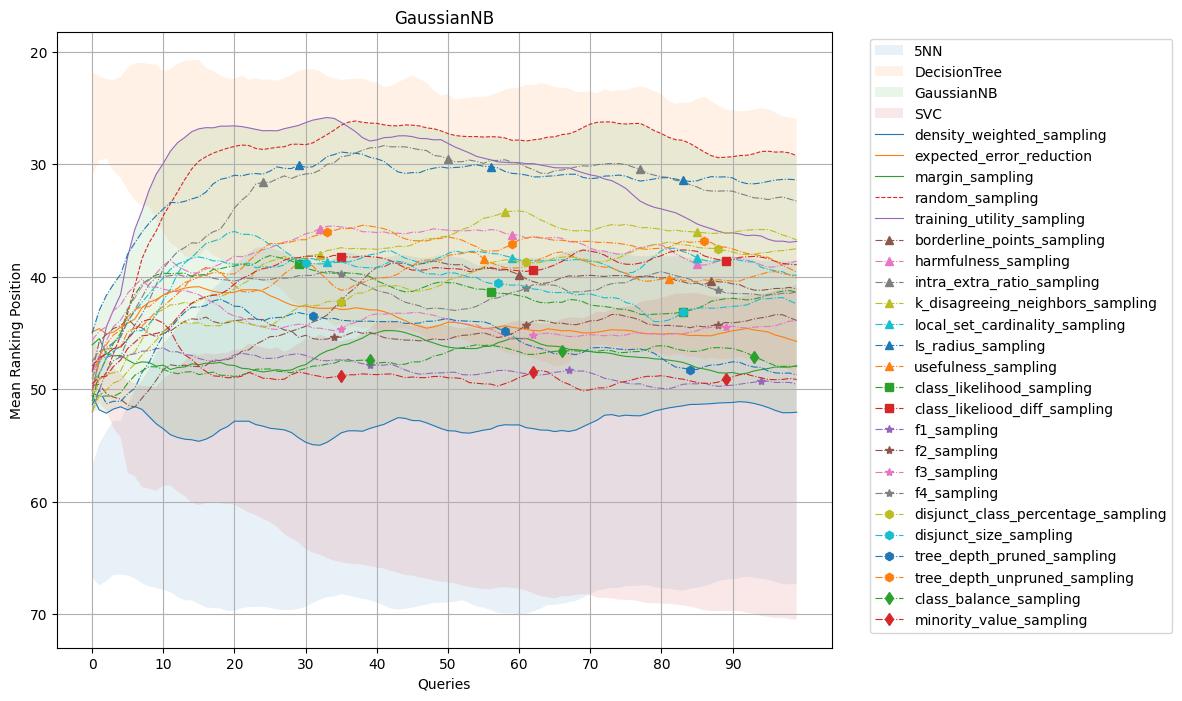

In [36]:
plot_ranks_with_bands(df, model='GaussianNB')

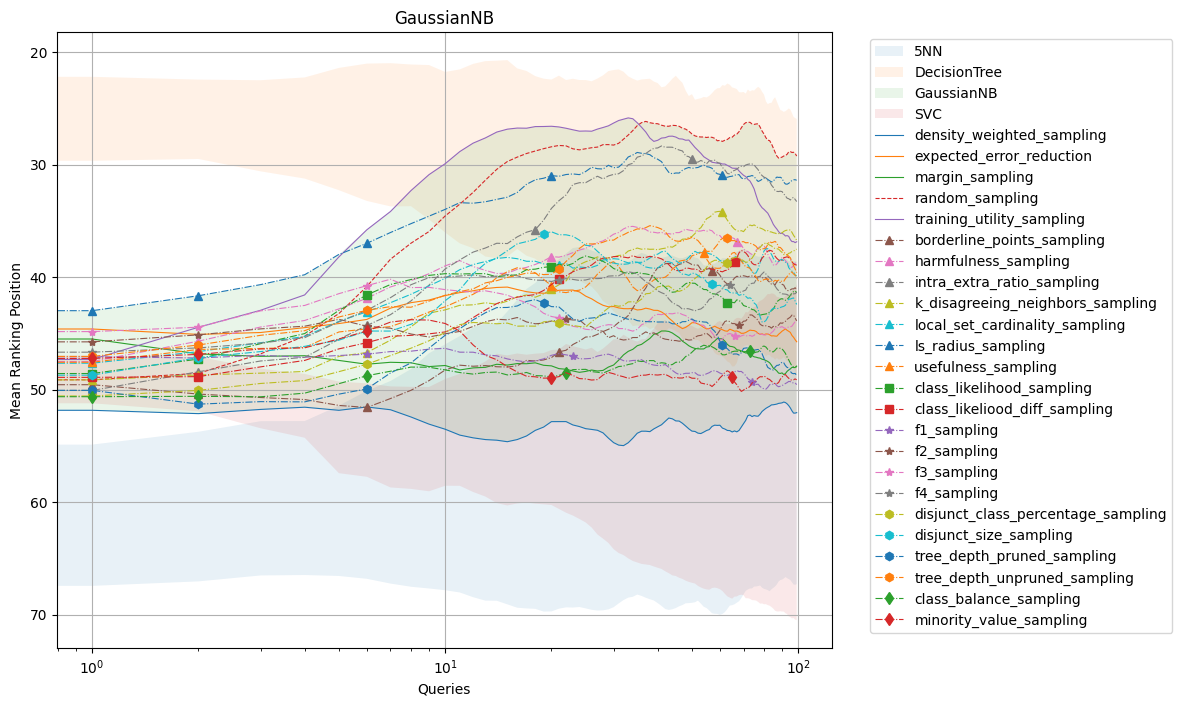

In [42]:
plot_ranks_with_bands(df, model='GaussianNB', log=True)

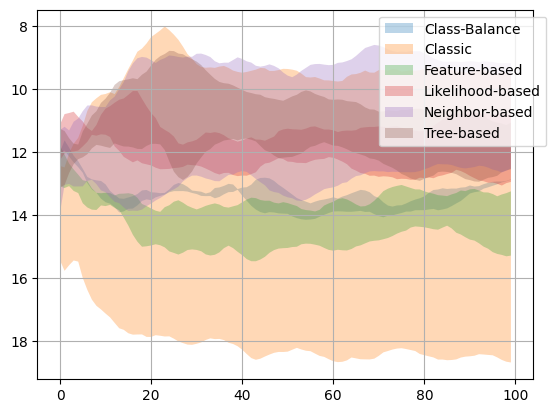

In [126]:
ranked_df = df.loc[:, "5NN", :].groupby('dataset').rank(ascending=False).groupby('strategy').mean()


ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

ranked_df_smoothed['type'] = ranked_df_smoothed.index.map(get_hm_type)

ranked_df_smoothed.set_index('type', append=True, inplace=True)

plt.grid()

for g, foo in ranked_df_smoothed.groupby('type'):
    plt.fill_between(np.arange(foo.shape[1]), foo.max(), foo.min(),
                     alpha=0.3, label=g)
plt.legend(bbox_to_anchor=(1.04,1), ncol=1)
plt.gca().invert_yaxis()



In [ ]:
def plot_ranks_with_bands(df, model=None, log=False):
    
    ranked_df = df.groupby('dataset').rank(ascending=False).groupby(['model','strategy']).mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')

    # Plot Bands
    for model_name, df in ranked_df_smoothed.groupby('model'):
        plt.fill_between(np.arange(df.shape[1]), df.max(), df.min(),
                         alpha=0.1, label=model_name)

    plt.title(model)
    if model is None:
    # Plot Best Strategy for each model
        for model, df in ranked_df_smoothed.groupby('model'):
            best_strategy = auc_series.loc[model].idxmax()
            
            plt.plot(ranked_df_smoothed.loc[model, best_strategy],
                     get_style(best_strategy),
                     label=' + '.join([model,best_strategy]),
                     markevery=(50,50),
                     linewidth=0.8)
            
            # worst_strategy = auc_series.loc[model].idxmin()
            # plt.plot(ranked_df_smoothed.loc[model, worst_strategy],
            #          get_style(best_strategy),
            #          label=' + '.join([model,worst_strategy]),
            #          markevery=(50,50),
            #          linewidth=0.8)
    else:
        
        color_list = sns.color_palette(n_colors=len(ranked_df_smoothed.columns))

        for i, (strategy, row) in  enumerate(ranked_df_smoothed.loc[model].iterrows()):
            plt.plot(ranked_df_smoothed.loc[model, strategy],
                     get_style(strategy),
                     label=strategy,
                     color=color_list[i],
                     markevery=(0.3, 0.2),
                     linewidth=0.8)
        

    plt.xticks(range(0, 100, 10))
    plt.grid()
    plt.xlabel('Queries')
    plt.ylabel('Mean Ranking Position')
    plt.legend(bbox_to_anchor=(1.04,1), ncol=1)
    plt.gca().invert_yaxis()

    if log == True:
        plt.xscale('log')
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(10, 8)